In [2]:
from preamble import *

In [3]:
df = pd.read_csv('./data/j_weather_data_v2.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.rename(columns={
    'outflow': 'inflow', 
    'input':'outflow'
  })
df['outflow'] = df['outflow'] / 60
df['inflow'] = df['inflow'] / 60
print(type(df), df.shape)

<class 'pandas.core.frame.DataFrame'> (15739, 9)


In [4]:
df.head()

,datetime,temperature,precipitation,wind_speed,humidity,atmospheric_pressure,snow,inflow,outflow
0,2023-01-01 00:00:00,-0.9,0.0,1.4,72.0,1023.6,0.0,77.88,101.05
1,2023-01-01 01:00:00,-1.3,0.0,1.5,74.0,1023.3,0.0,107.09,119.92
2,2023-01-01 02:00:00,-1.7,0.0,1.4,75.0,1023.1,0.0,143.67,124.54
3,2023-01-01 03:00:00,-2.0,0.0,1.2,77.0,1023.3,0.0,144.95,80.16
4,2023-01-01 04:00:00,-2.0,0.0,1.7,79.0,1022.8,0.0,159.06,104.88


In [9]:
df.loc[df['outflow'] <= 50, 'outflow'] = np.nan
median_value = df['outflow'].median()
df['outflow'] = df['outflow'].fillna(median_value)

In [10]:
target_variable = 'outflow'

1. 통계적 접근:

평균과 표준편차: 데이터의 분포를 나타내는 가장 기본적인 통계량인 평균과 표준편차를 사용합니다. 평균은 데이터의 중심 경향을 나타내고, 표준편차는 데이터가 평균에서 얼마나 흩어져 있는지를 나타냅니다.

정규 분포 가정: 이 방법은 데이터의 변화율이 대략적으로 정규 분포를 따른다는 가정을 기반으로 합니다. 실제 시계열 데이터의 변화율이 항상 정규 분포를 따르는 것은 아니지만, 많은 경우에 유사한 형태를 보입니다.

경험적 규칙: 평균에서 표준편차의 2배 이상 벗어난 값은 데이터의 약 5% 정도를 차지합니다. 이는 일반적으로 "이상치"로 간주할 수 있는 범위에 해당합니다 (정규 분포 가정 시).

직관적 이해: 평균에서 몇 배 표준편차만큼 벗어난 값들이 이상치로 간주되는 것에 대해 직관적으로 이해하기 쉽습니다.

2. 간편성 및 적용 용이성:

구현 용이성: 계산이 간단하고, 복잡한 알고리즘이나 라이브러리에 의존하지 않습니다.

빠른 초기 설정: 데이터 탐색 초기에 빠르게 이상치 탐지를 시도하고 결과를 확인할 수 있습니다.

일반적인 활용: 통계적 이상치 탐지 방법은 다양한 분야에서 사용되며, 일반적으로 적용하기 쉽습니다.

3. 장점:

데이터의 변동성 반영: 데이터의 변동성이 클수록 표준편차가 커지므로, 임곗값이 자동으로 높아져 데이터의 특성을 반영합니다.

탐지 강도 조절 용이: 표준편차의 배수를 변경하여 이상치 탐지의 민감도를 쉽게 조절할 수 있습니다. 예를 들어, 3배 표준편차를 사용하면 더 극단적인 이상치만 탐지할 수 있습니다.

다른 이상치 탐지 방법과 조합 용이: 다른 이상치 탐지 방법의 기본 임곗값으로 설정하여 활용할 수 있습니다.

4. 한계:

정규 분포 가정이 맞지 않을 경우: 실제 데이터의 변화율 분포가 정규 분포에서 크게 벗어난 경우(예: 극단적인 비대칭 분포) 이 방법의 효과가 떨어질 수 있습니다.

모든 이상치를 탐지 불가: 이 방법은 극단적인 이상치에 초점을 맞추기 때문에, 변화가 크지 않은 이상치나 시계열 데이터의 패턴에서 벗어난 이상치는 탐지하지 못할 수 있습니다.

수동 임곗값 조정 필요: 표준편차 배수와 같은 하이퍼파라미터의 수동 조정이 필요할 수 있습니다.

In [11]:
df_temp = df.copy()
df_temp['outflow_diff'] = df_temp[target_variable].diff().abs()
limit = 0.001 # df_temp['outflow_diff'][2019] = 0.0014899999996487168

flat_regions = []
start_index = None
for i, diff in enumerate(df_temp['outflow_diff']):
  if diff <= limit:
    if start_index is None:
      start_index = i
  elif start_index is not None:
    flat_regions.append((start_index, i - 1))
    start_index = None

# 마지막 구간 처리
if start_index is not None:
  flat_regions.append((start_index, len(df) -1))

print("Flat Regions:")
for start, end in flat_regions:
  print(f"Start: {start}, End: {end}")

Flat Regions:
Start: 3418, End: 3420
Start: 15738, End: 15738


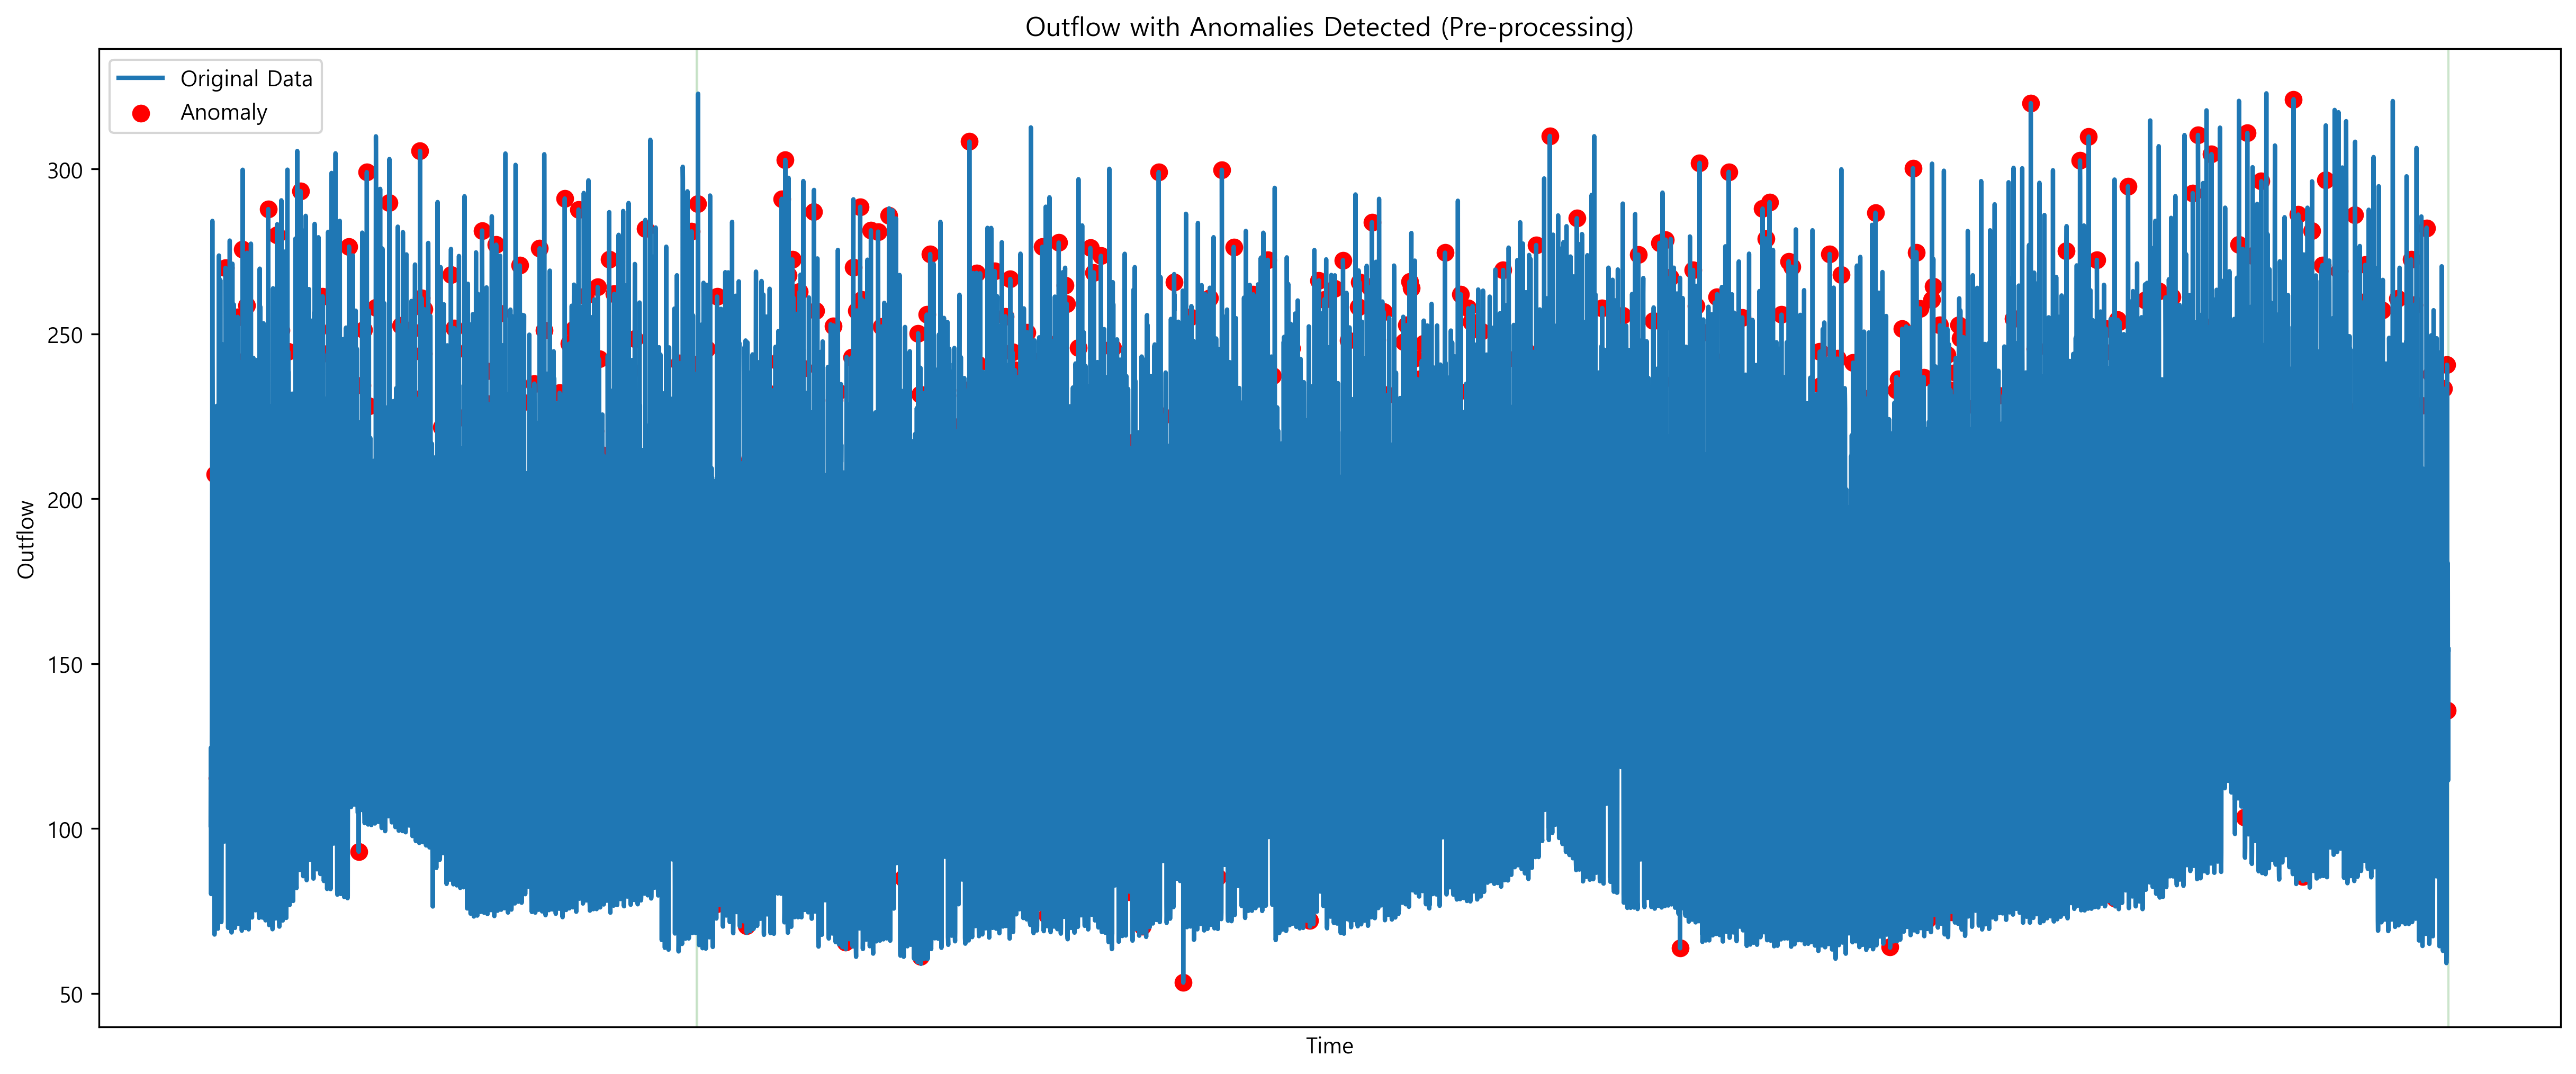

In [12]:
threshold = df_temp['outflow_diff'].mean() + 2 * df_temp['outflow_diff'].std()
anomaly_indices = df_temp[df_temp['outflow_diff'] > threshold].index.tolist()

plt.figure(figsize=(20, 8))
plt.xticks([])  # x축 눈금 제거
plt.plot(df.index, df['outflow'], label='Original Data')
plt.scatter(df.index[anomaly_indices], df['outflow'].iloc[anomaly_indices], color='red', label='Anomaly', s=50)
for start, end in flat_regions:
  plt.axvspan(df.index[start], df.index[end], color='green', alpha=0.2, label='Flat Region' if start == flat_regions[0] else None)
plt.xlabel('Time')
plt.ylabel('Outflow')
plt.title('Outflow with Anomalies Detected (Pre-processing)')
plt.legend()
plt.show()

In [ ]:
df_dropped = df_temp.drop(index=range(12303, 12518)).reset_index(drop=True)

In [9]:
anomaly_indices[0]

30

In [10]:
df_temp.loc[30, target_variable]

9922.65413

In [11]:
df_replace = df_dropped.drop('outflow_diff', axis=1)
for index in anomaly_indices:
  if index > 0 and index < len(df_replace) :
    df_replace.loc[index, target_variable] = df_replace.loc[index-1, target_variable]
  elif index == 0 and len(df_replace) > 1:
    df_replace.loc[index, target_variable] = df_replace.loc[index+1, target_variable]
df_cleaned = df_replace.copy()
print(f"Shape of data after replacing outliers : {df_cleaned.shape}")

Shape of data after replacing outliers : (15524, 9)


In [12]:
df_cleaned.loc[30, target_variable]

5695.90261

In [13]:
df_cleaned.head()

,datetime,temperature,precipitation,wind_speed,humidity,atmospheric_pressure,snow,outflow,input
0,2023-01-01 00:00:00,-0.9,0.0,1.4,72.0,1023.6,0.0,4672.98,6063.02
1,2023-01-01 01:00:00,-1.3,0.0,1.5,74.0,1023.3,0.0,6425.49,7195.35
2,2023-01-01 02:00:00,-1.7,0.0,1.4,75.0,1023.1,0.0,8620.11,7472.46
3,2023-01-01 03:00:00,-2.0,0.0,1.2,77.0,1023.3,0.0,8697.04,4809.88
4,2023-01-01 04:00:00,-2.0,0.0,1.7,79.0,1022.8,0.0,9543.70,6292.50


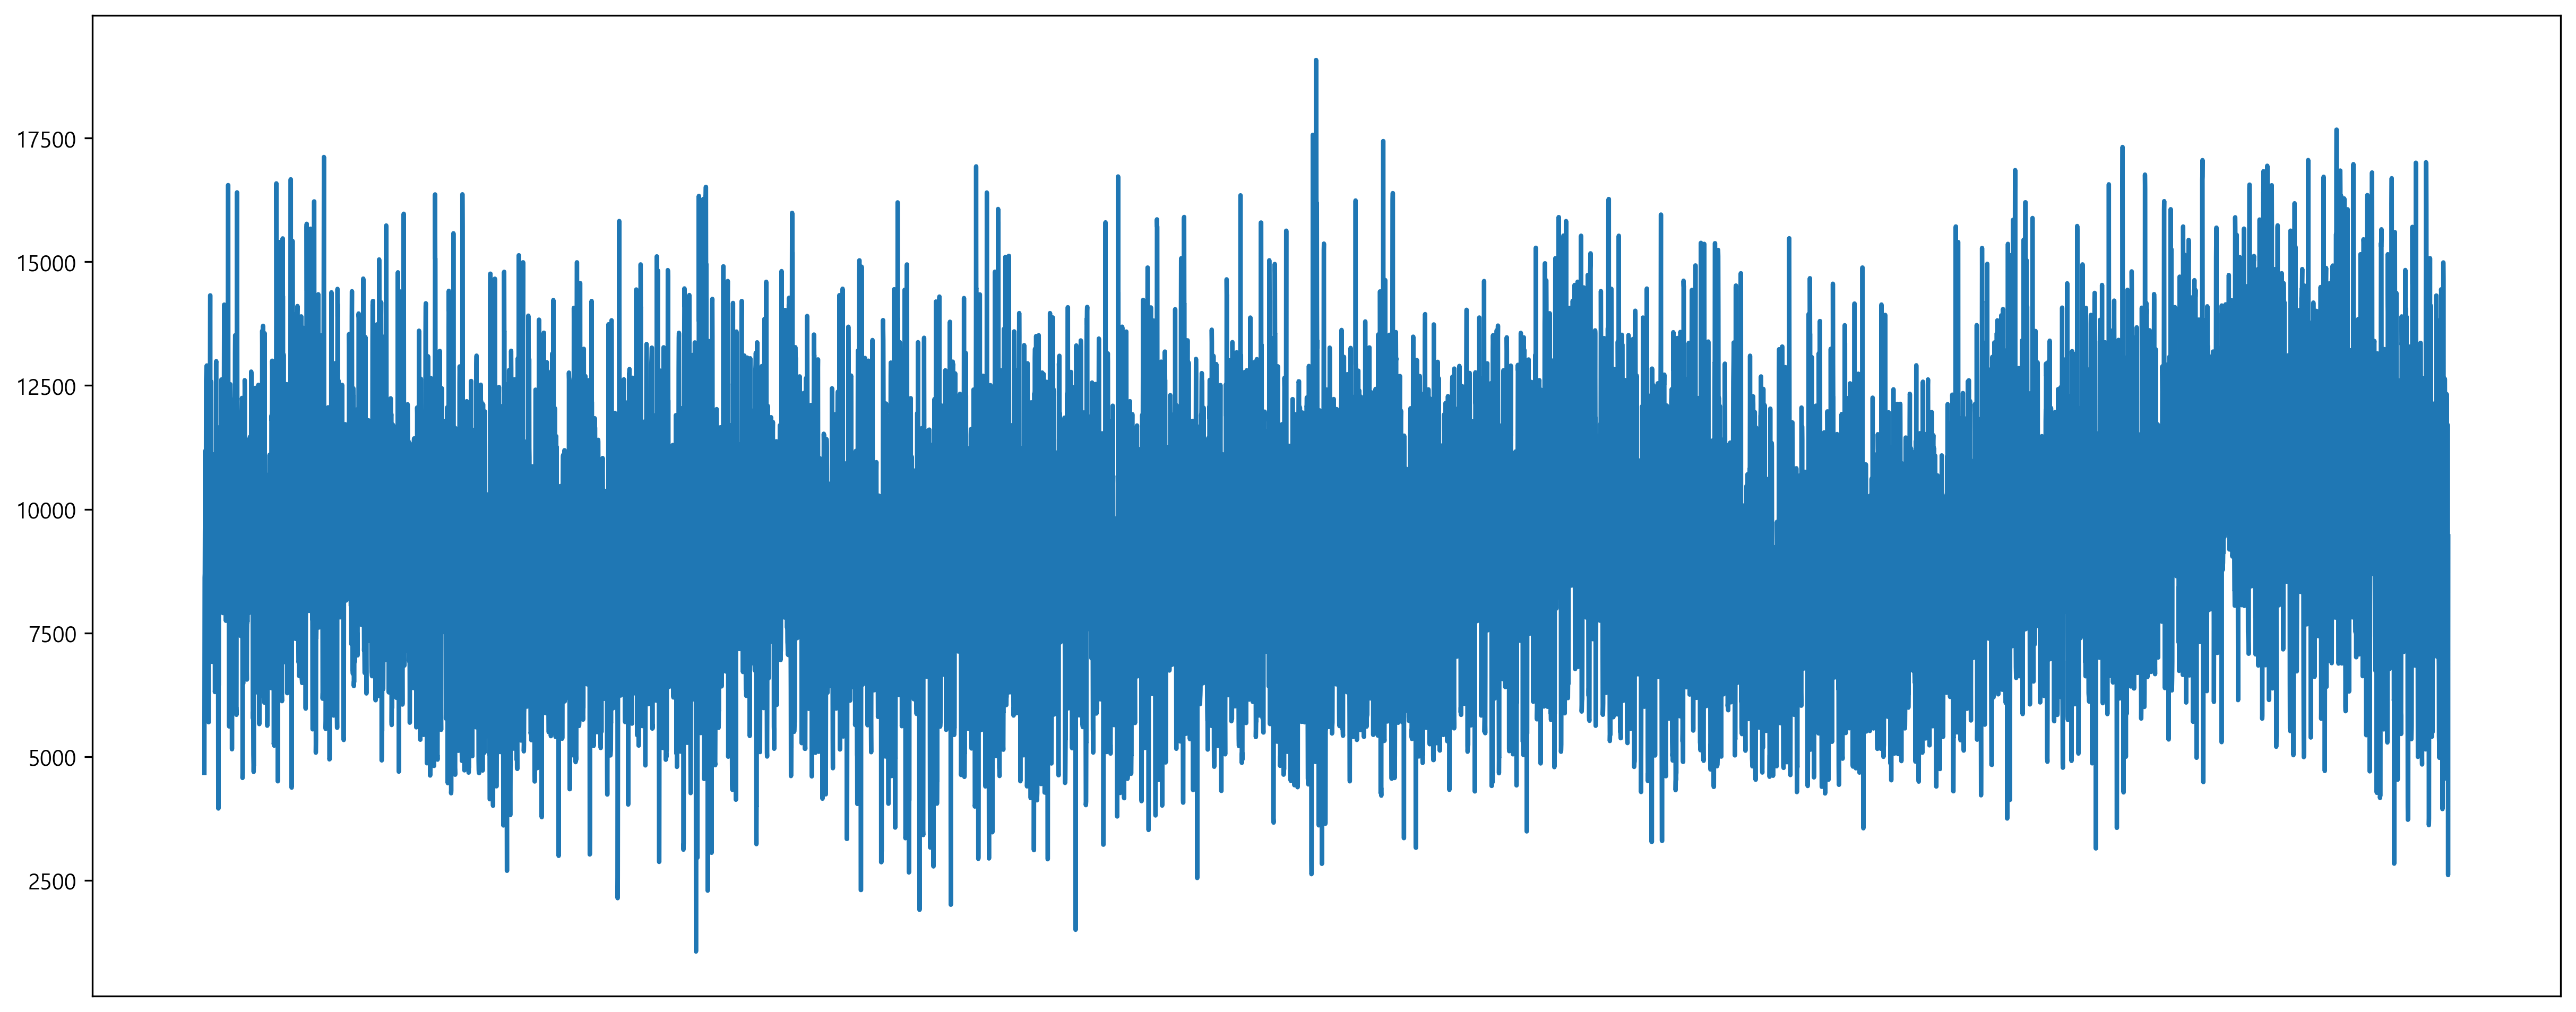

In [14]:
plt.figure(figsize=(20, 8))
plt.xticks([])  # x축 눈금 제거
plt.plot(df_cleaned.index, df_cleaned['outflow'], label='Cleaned Data')
plt.show()

In [15]:
feature = df_cleaned.reset_index(drop=True)
target = df_cleaned['outflow'].values.reshape(-1, 1)
feature.shape, target.shape

((15524, 9), (15524, 1))

In [16]:
feature['datetime'] = pd.to_datetime(feature['datetime'])

In [17]:
import holidays

kr_holidays = holidays.KR()
feature['is_weekend'] = feature['datetime'].dt.dayofweek >= 5 | feature['datetime'].isin(kr_holidays)
feature.head()

,datetime,temperature,precipitation,wind_speed,humidity,atmospheric_pressure,snow,outflow,input,is_weekend
0,2023-01-01 00:00:00,-0.9,0.0,1.4,72.0,1023.6,0.0,4672.98,6063.02,True
1,2023-01-01 01:00:00,-1.3,0.0,1.5,74.0,1023.3,0.0,6425.49,7195.35,True
2,2023-01-01 02:00:00,-1.7,0.0,1.4,75.0,1023.1,0.0,8620.11,7472.46,True
3,2023-01-01 03:00:00,-2.0,0.0,1.2,77.0,1023.3,0.0,8697.04,4809.88,True
4,2023-01-01 04:00:00,-2.0,0.0,1.7,79.0,1022.8,0.0,9543.70,6292.50,True


In [18]:
train_size = int(feature.shape[0] * 0.7)

trainset_feature = feature[:train_size]
trainset_target = target[:train_size]
testset_feature = feature[train_size:]
testset_target = target[train_size:]
print(trainset_feature.shape, testset_feature.shape)

(10866, 10) (4658, 10)


In [19]:
def create_time_feature(df): 
  df['dayofmonth'] = df['datetime'].dt.day 
  df['dayofweek'] = df['datetime'].dt.dayofweek 
  df['quarter'] = df['datetime'].dt.quarter 
  df['month'] = df['datetime'].dt.month 
  df['year'] = df['datetime'].dt.year 
  df['dayofyear'] = df['datetime'].dt.dayofyear 
  df['week'] = df['datetime'].dt.isocalendar().week
  df['hour'] = df['datetime'].dt.hour
  df['minute'] = df['datetime'].dt.minute
  df['second'] = df['datetime'].dt.second
  return df

In [20]:
trainset_feature = create_time_feature(trainset_feature)
testset_feature = create_time_feature(testset_feature)

C:\Users\user\AppData\Local\Temp\ipykernel_17996\1880899018.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dayofmonth'] = df['datetime'].dt.day
C:\Users\user\AppData\Local\Temp\ipykernel_17996\1880899018.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dayofweek'] = df['datetime'].dt.dayofweek
C:\Users\user\AppData\Local\Temp\ipykernel_17996\1880899018.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

In [36]:
trainset_feature.head()

,temperature,precipitation,wind_speed,humidity,atmospheric_pressure,snow,outflow,input,is_weekend,dayofmonth,dayofweek,quarter,month,year,dayofyear,week,hour,minute,second
0,-0.9,0.0,1.4,72.0,1023.6,0.0,4672.98,6063.02,True,1,6,1,1,2023,1,52,0,0,0
1,-1.3,0.0,1.5,74.0,1023.3,0.0,6425.49,7195.35,True,1,6,1,1,2023,1,52,1,0,0
2,-1.7,0.0,1.4,75.0,1023.1,0.0,8620.11,7472.46,True,1,6,1,1,2023,1,52,2,0,0
3,-2.0,0.0,1.2,77.0,1023.3,0.0,8697.04,4809.88,True,1,6,1,1,2023,1,52,3,0,0
4,-2.0,0.0,1.7,79.0,1022.8,0.0,9543.70,6292.50,True,1,6,1,1,2023,1,52,4,0,0


In [21]:
trainset_feature.drop('datetime', axis=1, inplace=True)
testset_feature.drop('datetime', axis=1, inplace=True)

C:\Users\user\AppData\Local\Temp\ipykernel_17996\419025515.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trainset_feature.drop('datetime', axis=1, inplace=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17996\419025515.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testset_feature.drop('datetime', axis=1, inplace=True)


In [22]:
from sklearn.preprocessing import MinMaxScaler

scaler_feature = MinMaxScaler()
train_feature_scaled = scaler_feature.fit_transform(trainset_feature)
test_feature_scaled = scaler_feature.transform(testset_feature)

scaler_target = MinMaxScaler()
train_target_scaled = scaler_target.fit_transform(trainset_target)
test_target_scaled = scaler_target.transform(testset_target)

In [26]:
import pickle

with open('scaler_feature_lstm.pkl', 'wb') as f:
    pickle.dump(scaler_feature, f)
with open('scaler_target_lstm.pkl', 'wb') as f:
    pickle.dump(scaler_target, f)

In [24]:
valid_size = int(train_feature_scaled.shape[0] * 0.9)
train_feature_scale = train_feature_scaled[:valid_size]
train_target_scale = train_target_scaled[:valid_size]
valid_feature_scaled = train_feature_scaled[valid_size:]
valid_target_scaled = train_target_scaled[valid_size:]

In [25]:
train_feature_scale.shape[0], valid_size, valid_feature_scaled.shape

(9781, 9781, (1087, 19))

In [26]:
def split_dataset(data, target, seq_len, pred_len):
  X, y = [], []
  for i in range(data.shape[0] - (seq_len + pred_len) + 1):
    X.append(data[i:i + seq_len, :])
    y.append(target[i + seq_len:i + seq_len + pred_len])
  return np.array(X), np.array(y)

seq_len = 168
pred_len = 24

In [27]:
X_train, y_train = split_dataset(train_feature_scaled, train_target_scaled, seq_len, pred_len)

In [28]:
X_train.shape, y_train.shape

((10677, 168, 19), (10677, 24, 1))

In [29]:
X_valid, y_valid = split_dataset(valid_feature_scaled, valid_target_scaled, seq_len, pred_len)

In [30]:
X_valid.shape, y_valid.shape

((896, 168, 19), (896, 24, 1))

In [31]:
X_test, y_test = split_dataset(test_feature_scaled, test_target_scaled, seq_len, pred_len)

In [32]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((10677, 168, 19), (10677, 24, 1), (4468, 168, 19), (4468, 24, 1))

In [33]:
X_train[0].shape

(168, 19)

In [34]:
X_train_tensor, y_train_tensor = torch.tensor(X_train).float(), torch.tensor(y_train).float()
X_valid_tensor, y_valid_tensor = torch.tensor(X_valid).float(), torch.tensor(y_valid).float()
X_test_tensor, y_test_tensor = torch.tensor(X_test).float(), torch.tensor(y_test).float()

In [35]:
from torch.utils.data import DataLoader, TensorDataset

loader_train = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), shuffle=True,
                                           batch_size=128)
loader_valid = DataLoader(TensorDataset(X_valid_tensor, y_valid_tensor), shuffle=True,
                                           batch_size=128)
loader_test = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), shuffle=False,
                                          batch_size=128)

In [28]:
class LSTMModel(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(LSTMModel, self).__init__()
    self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
    self.fc = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    lstm_out, _ = self.lstm(x)
    last_out = lstm_out[:, -1, :]
    out = self.fc(last_out)
    return out

input_size = 19
hidden_size = 50
output_size = 24
model = LSTMModel(input_size, hidden_size, output_size)


In [37]:
for I, label in loader_train:
  print(model(I)[0], label[0])
  break

tensor([-0.1006, -0.0163, -0.0330, -0.0785, -0.1434, -0.0113,  0.0500,  0.1762,
         0.0054,  0.0928, -0.0780,  0.0375, -0.2124,  0.1810, -0.1126,  0.1094,
        -0.0275,  0.0638,  0.0883,  0.0947,  0.1402, -0.0627,  0.0635, -0.0278],
       grad_fn=<SelectBackward0>) tensor([[0.4863],
        [0.4858],
        [0.4784],
        [0.4796],
        [0.4864],
        [0.4937],
        [0.4208],
        [0.3656],
        [0.3625],
        [0.3707],
        [0.2354],
        [0.2446],
        [0.2618],
        [0.2127],
        [0.2127],
        [0.4391],
        [0.4391],
        [0.7524],
        [0.7461],
        [0.7461],
        [0.5559],
        [0.5323],
        [0.5301],
        [0.5289]])


In [38]:
import torch.optim as optim

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device, torch.__version__, torch.cuda.is_available()

(device(type='cuda'), '2.5.1', True)

In [40]:
def evaluate(model, valid_dataset, criterion, device):
  val_loss = 0
  model.eval()
  with torch.no_grad():
    for batch_X, batch_y in valid_dataset:
      batch_X, batch_y = batch_X.to(device), batch_y.to(device)
      logits =model(batch_X)
      batch_y = batch_y.view(batch_y.size(0), -1)
      loss = criterion(logits, batch_y)
      val_loss += loss.item()
  return val_loss

In [ ]:
best_valid_loss = float('inf')
num_epochs = 200
model.to(device)
for epoch in range(num_epochs):
  model.train()
  train_loss = 0.0
  for X, y in loader_train:
    X_batch, y_batch = X.to(device), y.to(device)

    out = model(X_batch)
    y_batch = y_batch.view(y_batch.size(0), -1)
    loss = loss_fn(out, y_batch)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss += loss.item()

  loss_history.append(train_loss / len(loader_train.dataset))
  valid_loss = evaluate(model, loader_valid, loss_fn, device)
  print(f'Epoch : {epoch + 1} / {num_epochs}')
  print(f'Train Loss : {train_loss}')
  print(f'Valid Loss : {valid_loss}')
  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(model.state_dict(), 'best_lstm_checkpoint.pt')

Epoch : 1 / 200
Train Loss : 3.944366594776511
Valid Loss : 0.14241699315607548
Epoch : 2 / 200
Train Loss : 1.5993650164455175
Valid Loss : 0.1334096509963274
Epoch : 3 / 200
Train Loss : 1.4234318332746625
Valid Loss : 0.11014812905341387
Epoch : 4 / 200
Train Loss : 1.1879224684089422
Valid Loss : 0.0948218060657382
Epoch : 5 / 200
Train Loss : 1.0932799559086561
Valid Loss : 0.08758040890097618
Epoch : 6 / 200
Train Loss : 1.046576377004385
Valid Loss : 0.08255985844880342
Epoch : 7 / 200
Train Loss : 0.9836737746372819
Valid Loss : 0.07764510624110699
Epoch : 8 / 200
Train Loss : 0.9352112226188183
Valid Loss : 0.07890622969716787
Epoch : 9 / 200
Train Loss : 0.9239980019629002
Valid Loss : 0.07424698676913977
Epoch : 10 / 200
Train Loss : 0.9207717692479491
Valid Loss : 0.07581822667270899
Epoch : 11 / 200
Train Loss : 0.9164121132344007
Valid Loss : 0.07536162063479424
Epoch : 12 / 200
Train Loss : 0.9115865174680948
Valid Loss : 0.07480518147349358
Epoch : 13 / 200
Train Loss :

In [ ]:
model.load_state_dict(torch.load('best_lstm_checkpoint.pt'))
model.to(device)

C:\Users\user\AppData\Local\Temp\ipykernel_17996\1702020523.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_lstm_checkpoint.pt'))


LSTMModel(
  (lstm): LSTM(19, 50, batch_first=True)
  (fc): Linear(in_features=50, out_features=24, bias=True)
)

In [38]:
data = pd.read_csv('./data/j_weather_data_October_v3.csv')
data['datetime'] = pd.to_datetime(data['datetime']) 

In [39]:
with open('scaler_feature_lstm.pkl', 'rb') as f:
  loaded_scaler_feature = pickle.load(f)
with open('scaler_target_lstm.pkl', 'rb') as f:
  loaded_scaler_target = pickle.load(f)

def predict(dt, model):  # dt는 datetime 객체
  model.eval()

  # dt를 기준으로 이전 168개의 데이터 가져오기
  past_data = data[data['datetime'] < dt].tail(168)

  if len(past_data) != 168:
    raise ValueError("이전 168개의 데이터를 찾을 수 없습니다.")

  # 과거 데이터를 numpy array로 변환하고, float32 타입으로 변경
  input_data = past_data.drop('datetime', axis=1).values.astype(np.float32)
  scaled_input_data = loaded_scaler_feature.transform(input_data)

  # 데이터를 PyTorch Tensor로 변환하고, 모델에 입력할 수 있도록 reshape
  input_tensor = torch.tensor(scaled_input_data).unsqueeze(0).to(device) # (batch_size, sequence_length, input_size)

  with torch.no_grad():
    predicted = model(input_tensor)

  predicted = predicted.cpu().numpy()

  predicted_original = loaded_scaler_target.inverse_transform(predicted)

  return predicted_original.tolist()

prediction = predict('2023-10-21T00:00', model)
print(prediction)

[[6835.02197265625, 6220.08447265625, 5509.9619140625, 5073.1142578125, 5069.36279296875, 5617.2236328125, 6704.107421875, 8083.9677734375, 9021.3154296875, 9870.4326171875, 10488.728515625, 10551.935546875, 10961.3193359375, 10924.54296875, 11086.4990234375, 10837.5029296875, 10571.828125, 10411.76953125, 10023.796875, 9973.2060546875, 10234.3408203125, 10610.046875, 10566.251953125, 10323.0556640625]]


c:\DevTool\anaconda3\envs\torch_book\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [49]:
model.eval()

y_pred_list = []
with torch.no_grad():
  for X_batch, _ in loader_test:
    X_batch = X_batch.to(device)
    # y_pred = model(X_batch).numpy()
    y_pred = model(X_batch).cpu().numpy()
    y_pred_list.append(y_pred)

y_pred = np.concatenate(y_pred_list, axis=0)

In [44]:
from sklearn.metrics import mean_squared_error, r2_score

y_test_ori = scaler_target.inverse_transform(y_test.reshape(-1, pred_len))
y_pred_ori = scaler_target.inverse_transform(y_pred)

mse = mean_squared_error(y_test.reshape(-1, pred_len), y_pred)
mse_ori = mean_squared_error(y_test_ori, y_pred_ori)
rmse = np.sqrt(mse)
rmse_ori = np.sqrt(mse_ori)
r2 = r2_score(y_test.reshape(-1, pred_len), y_pred)
print(f'RMSE : {rmse}, RMSE_ORI : {rmse_ori} R-value : {r2}')

RMSE : 0.14097089752669203, RMSE_ORI : 2539.6421422283925 R-value : -0.00345075756494082


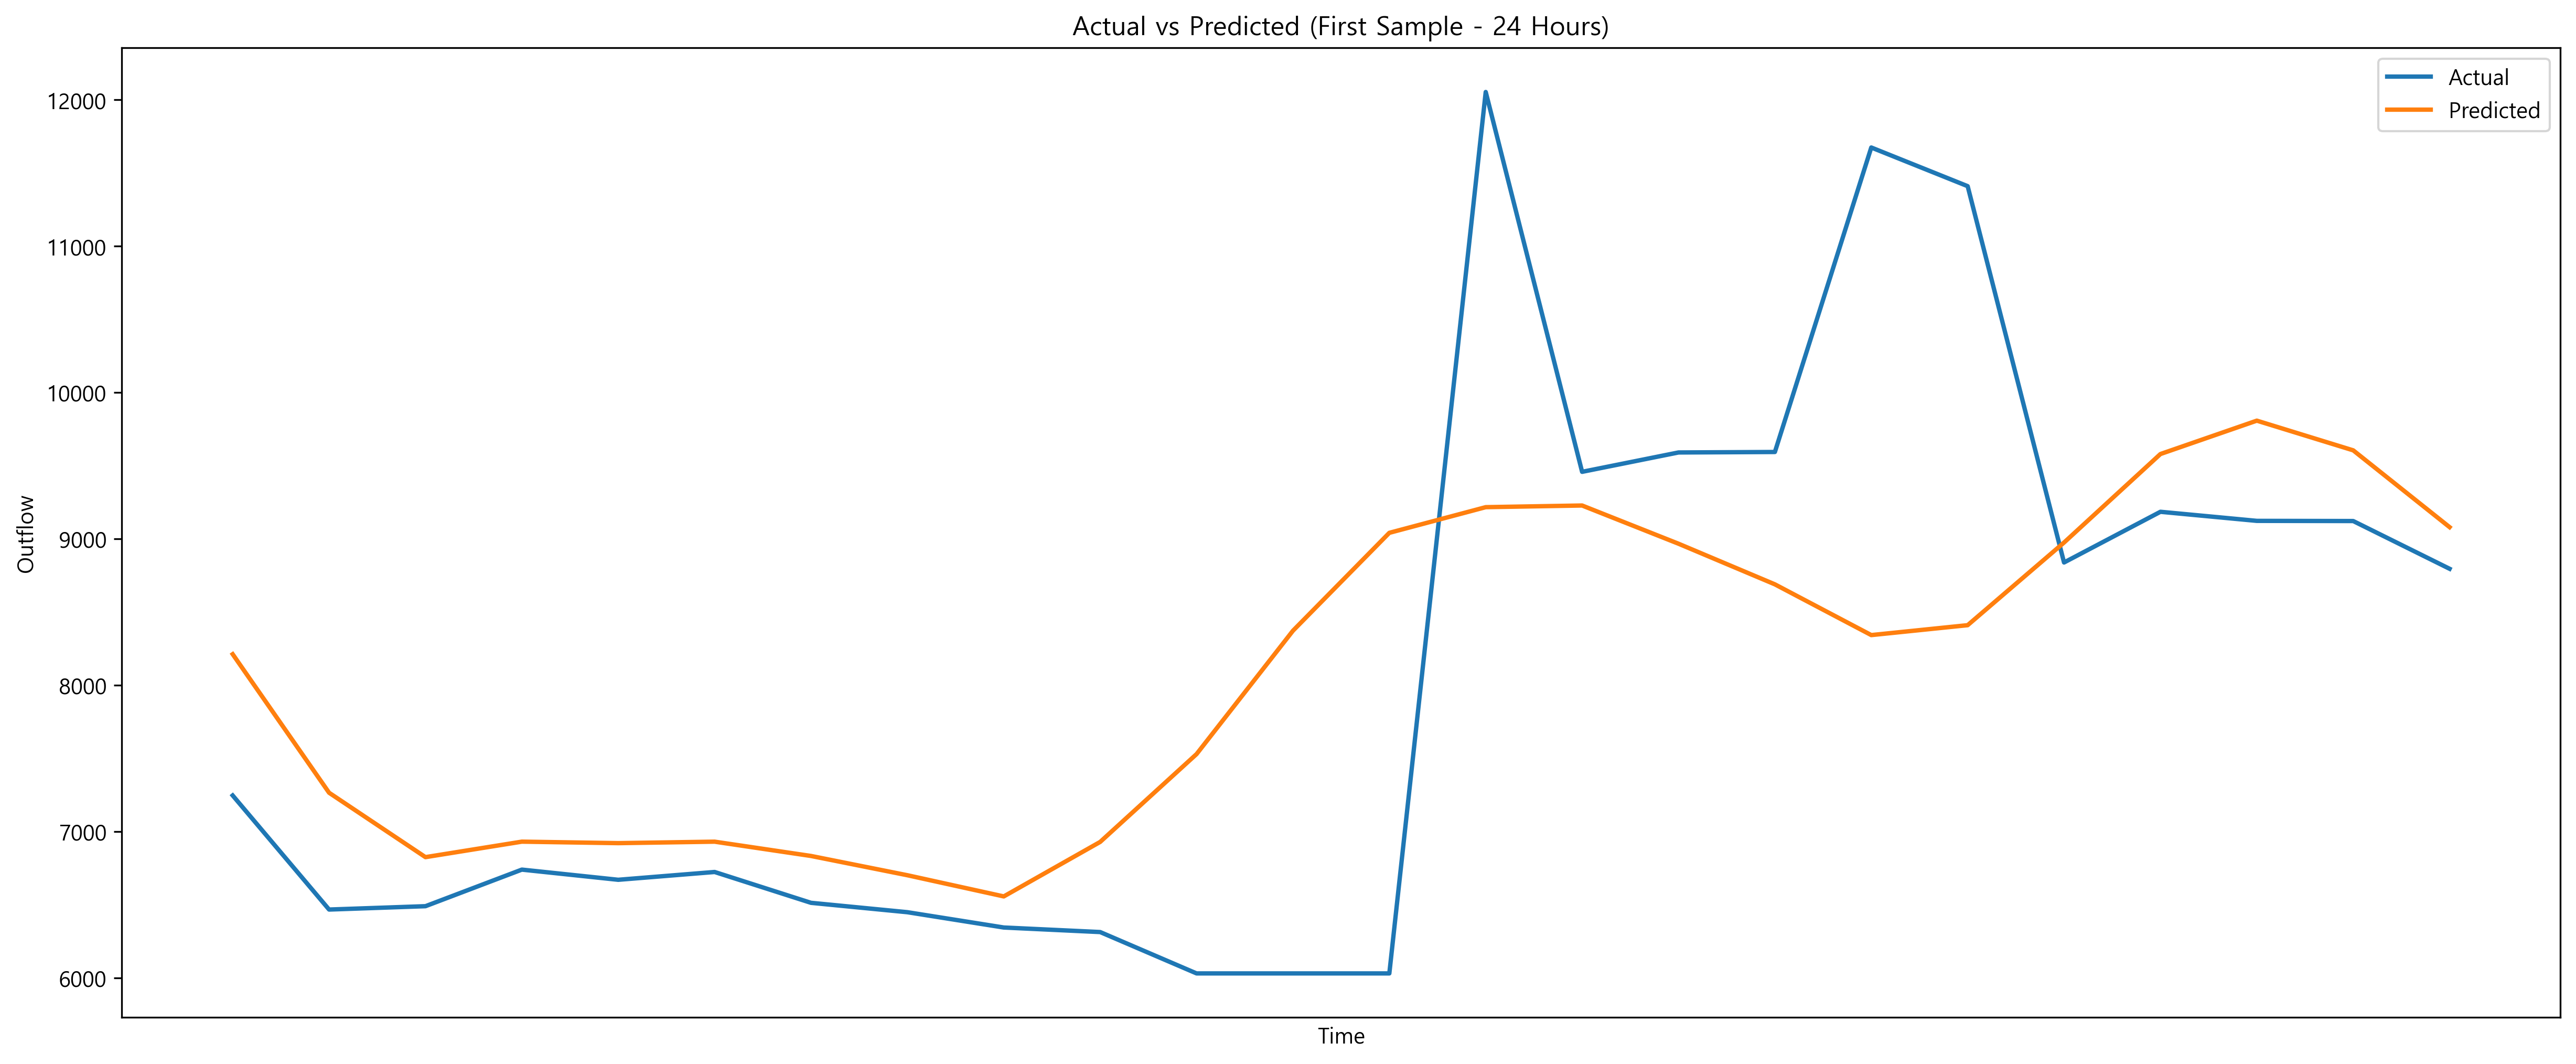

In [45]:
# 예측 결과 시각화 (첫 번째 샘플의 24시간 예측)
plt.figure(figsize=(20, 8))
plt.xticks([])  # x축 눈금 제거

# 첫 번째 샘플의 실제값
actual_data = y_test_ori[0]
# 첫 번째 샘플의 예측값
predicted_data = y_pred_ori[0]

# 시간 인덱스 설정
time_index = df.index[train_size + seq_len:train_size + seq_len + pred_len]

plt.plot(time_index, actual_data, label='Actual')
plt.plot(time_index, predicted_data, label='Predicted')
plt.legend()
plt.title('Actual vs Predicted (First Sample - 24 Hours)')
plt.xlabel('Time')
plt.ylabel('Outflow')
plt.show()

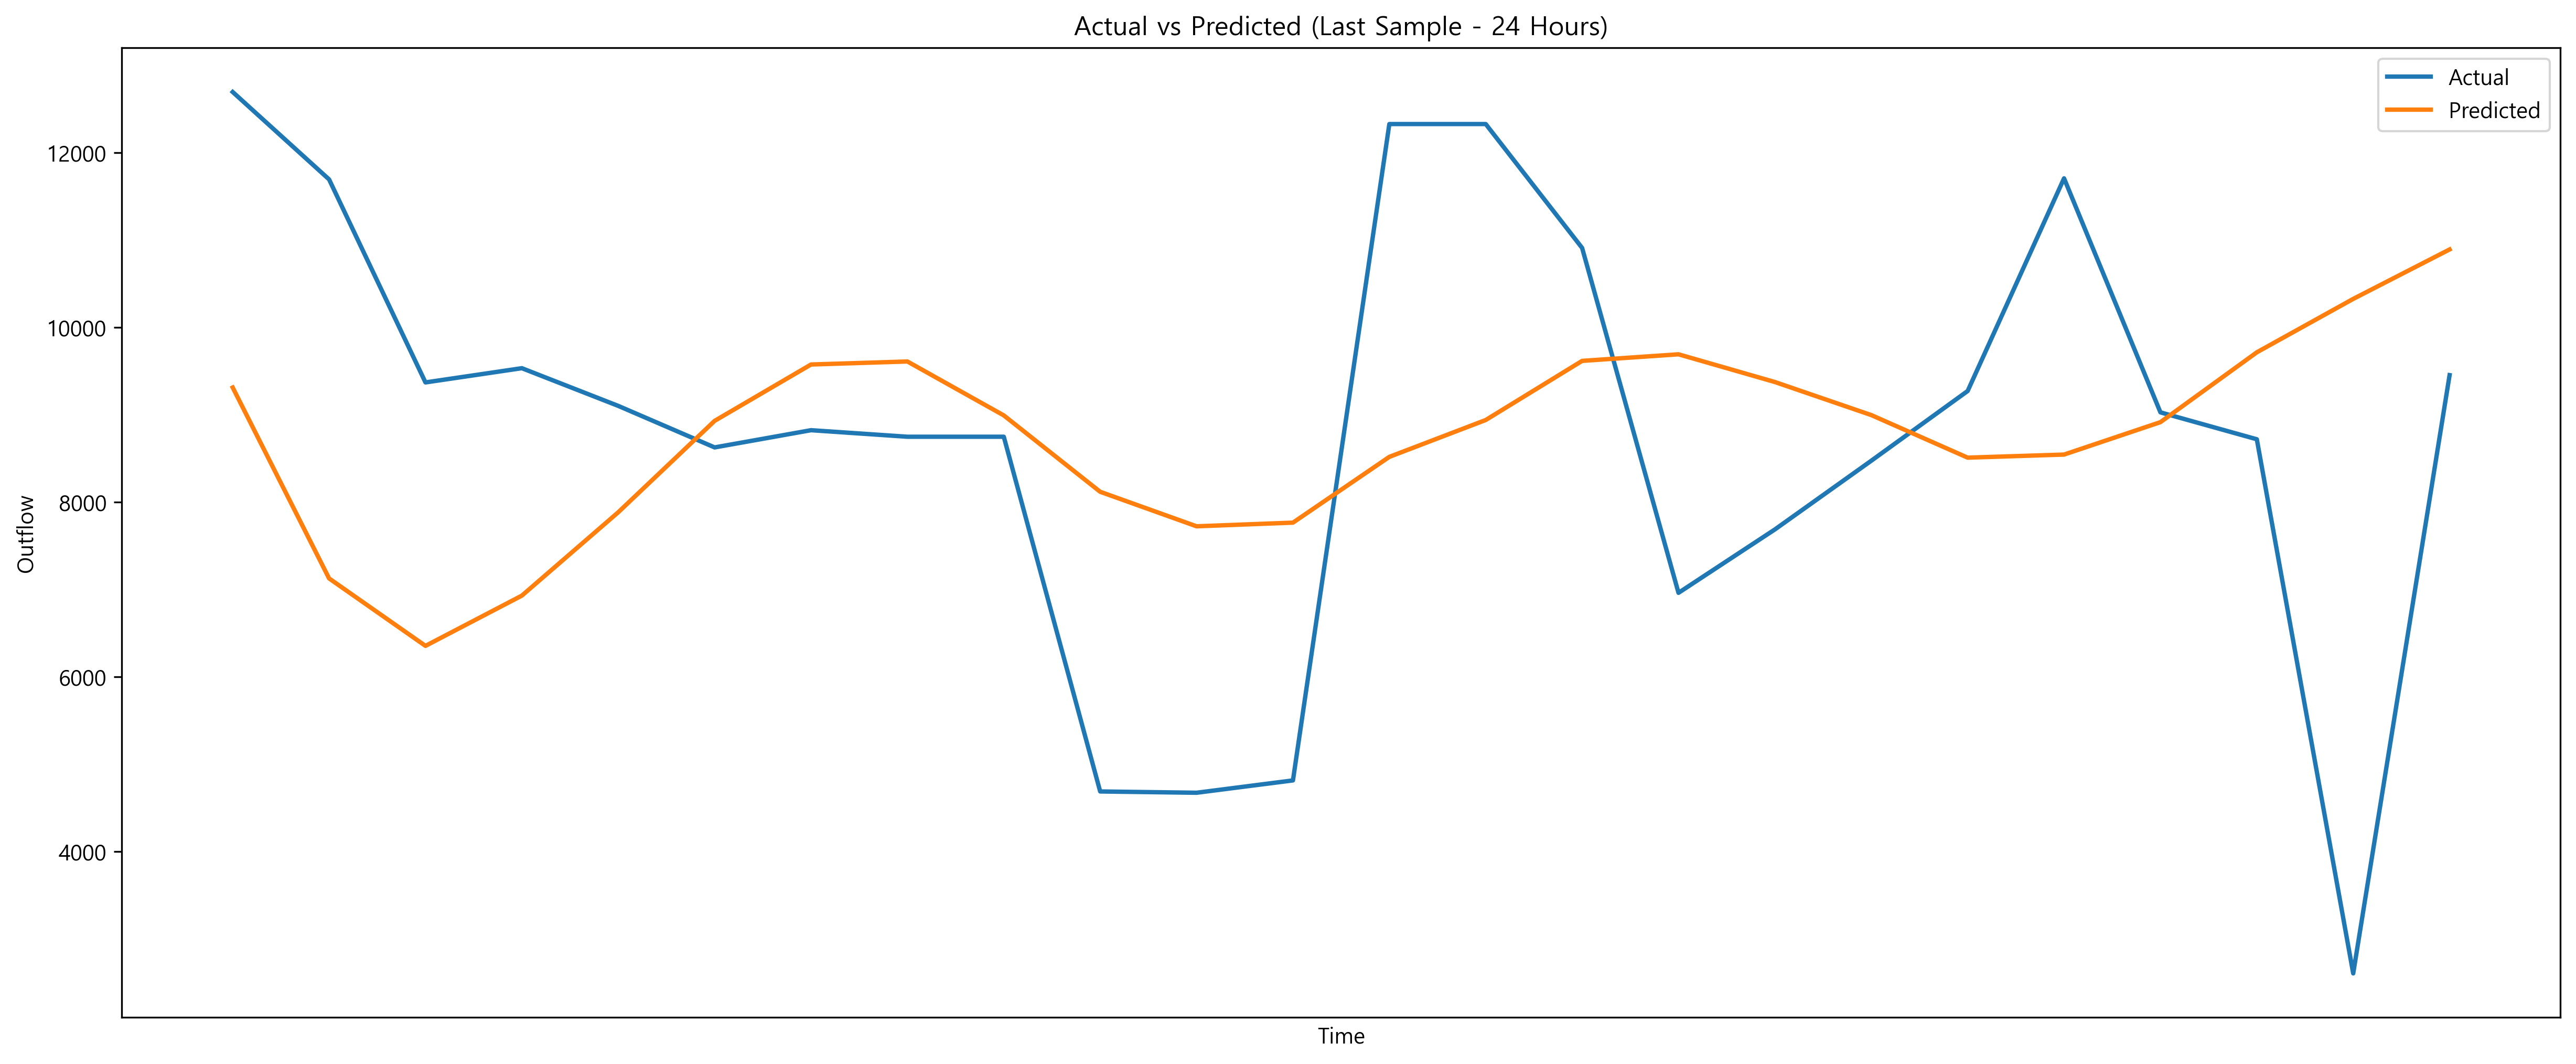

In [46]:
plt.figure(figsize=(20, 8))
plt.xticks([])  # x축 눈금 제거

# 마지막 샘플의 실제값
actual_data = y_test_ori[-1]
predicted_data = y_pred_ori[-1]

start_index = train_size + seq_len + (len(y_test)-1)
time_index = df.index[start_index:start_index + pred_len]


plt.plot(time_index, actual_data, label='Actual')
plt.plot(time_index, predicted_data, label='Predicted')
plt.legend()
plt.title('Actual vs Predicted (Last Sample - 24 Hours)')
plt.xlabel('Time')
plt.ylabel('Outflow')
plt.show()

In [48]:
y_pred_ori[0]

array([8212.191, 7265.414, 6825.266, 6931.12 , 6920.984, 6931.015,
       6833.307, 6701.615, 6556.853, 6929.276, 7529.53 , 8372.543,
       9041.579, 9216.979, 9228.309, 8967.19 , 8689.547, 8342.821,
       8410.429, 8975.304, 9580.065, 9808.205, 9605.35 , 9080.394],
      dtype=float32)